In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
class VGG(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)

        )


        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



In [3]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64,
                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64,
                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170M/170M [00:08<00:00, 20.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]

In [5]:
def show_data(img):
    try:
        plt.imshow(img[0])
    except Exception as e:
        print(e)
    print(img[0].shape, img[0].permute(1,2,0).shape)
    plt.imshow(img[0].permute(1,2,0))
    plt.title(classes[img[1]])
    plt.show()


def im_convert(tensor):
    img = tensor.cpu().clone().detach().numpy() #
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1)
    return img

Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


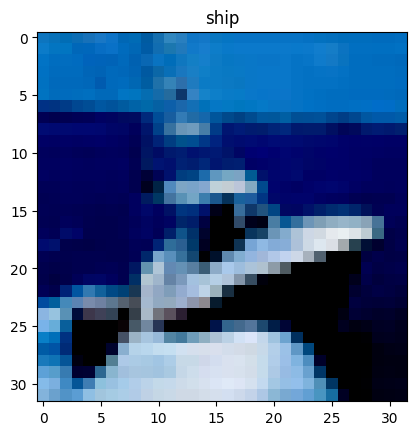

In [6]:
show_data(trainset[8])

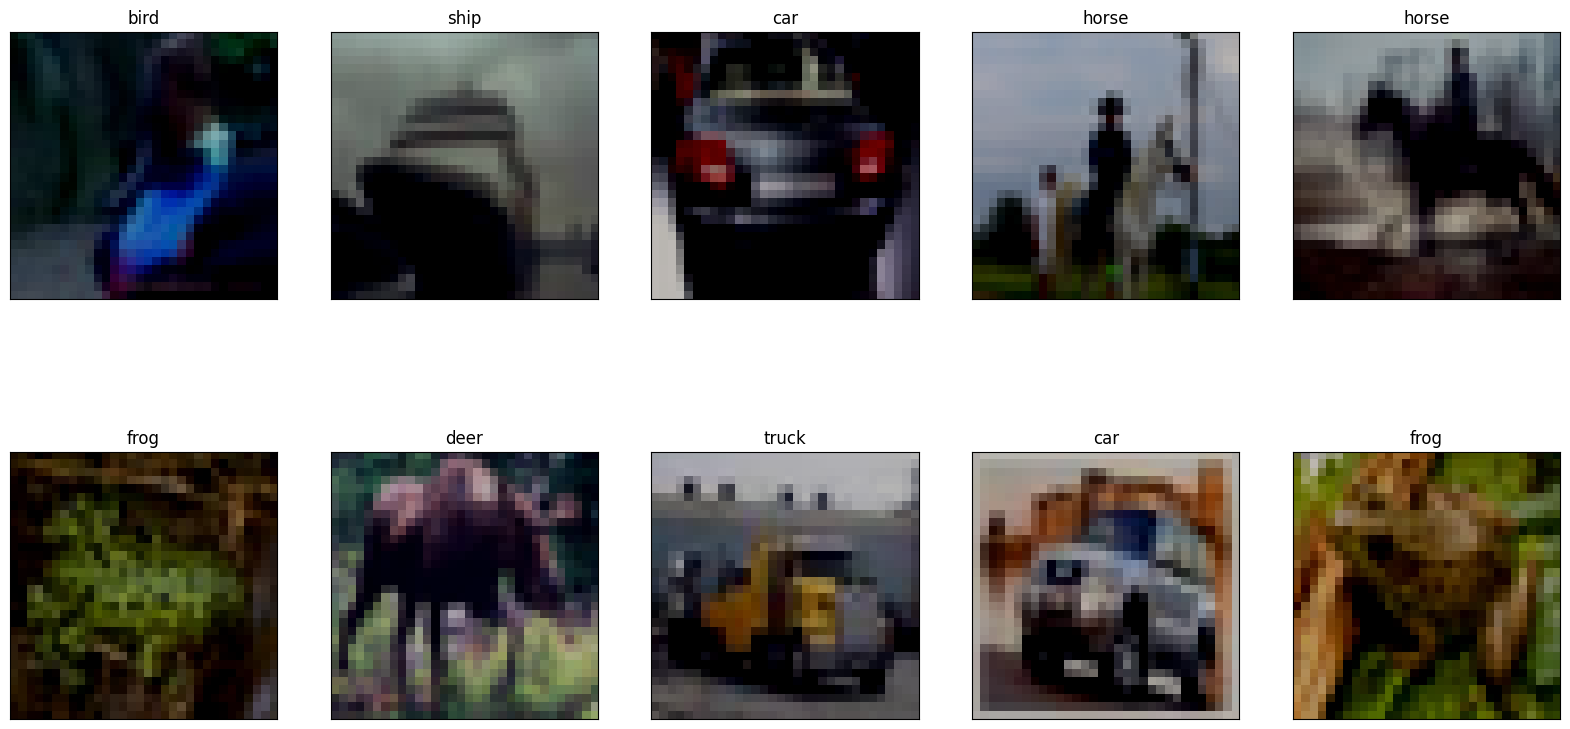

In [7]:
data_iterable = iter(trainloader)
images, labels = next(data_iterable)
fig = plt.figure(figsize=(20, 10))

for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
device

device(type='cuda', index=0)

In [11]:
model = VGG(num_classes=len(classes)).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# Обучение модели с подсчетом accuracy на тренировочном наборе
num_epochs = 50
list_loss = []
list_acc = []

for epoch in range(num_epochs):
    timestart = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Подсчет accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    list_loss.append(running_loss / len(trainloader))
    list_acc.append(train_accuracy)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(trainloader):.4f}, Accuracy: {train_accuracy:.2f}%, Time: {time.time() - timestart}')


Epoch [1/50], Loss: 1.6718, Accuracy: 37.07%, Time: 23.494166374206543
Epoch [2/50], Loss: 1.2834, Accuracy: 53.05%, Time: 22.193487644195557
Epoch [3/50], Loss: 1.0620, Accuracy: 61.89%, Time: 22.45573616027832
Epoch [4/50], Loss: 0.8864, Accuracy: 68.52%, Time: 22.09034538269043
Epoch [5/50], Loss: 0.7480, Accuracy: 73.60%, Time: 22.085057735443115
Epoch [6/50], Loss: 0.6423, Accuracy: 77.40%, Time: 22.512498140335083
Epoch [7/50], Loss: 0.5474, Accuracy: 80.75%, Time: 22.5701687335968
Epoch [8/50], Loss: 0.4460, Accuracy: 84.39%, Time: 21.895670652389526
Epoch [9/50], Loss: 0.3631, Accuracy: 87.31%, Time: 23.103387117385864
Epoch [10/50], Loss: 0.2827, Accuracy: 90.13%, Time: 23.43944025039673
Epoch [11/50], Loss: 0.2158, Accuracy: 92.45%, Time: 22.997504949569702
Epoch [12/50], Loss: 0.1579, Accuracy: 94.53%, Time: 22.061225652694702
Epoch [13/50], Loss: 0.1190, Accuracy: 95.91%, Time: 22.734930753707886
Epoch [14/50], Loss: 0.1021, Accuracy: 96.52%, Time: 22.798648357391357
Epoch 

In [12]:
model.eval()  # Устанавливаем модель в режим оценки
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')


Accuracy of the network on the test images: 80.65%


Text(0, 0.5, 'Loss')

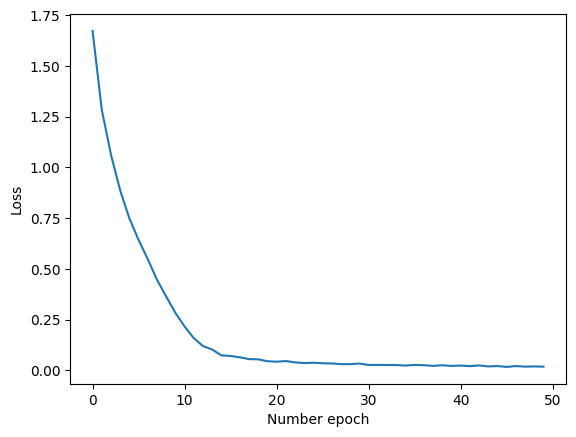

In [13]:
plt.plot(list_loss)
plt.xlabel('Number epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'Accuracy')

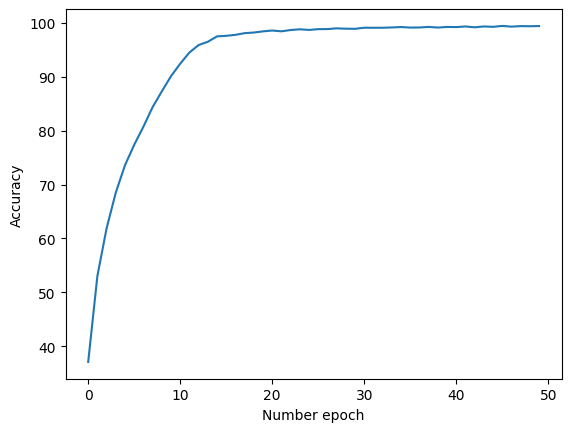

In [14]:
plt.plot(list_acc)
plt.xlabel('Number epoch')
plt.ylabel('Accuracy')